# Fine-tune GIT on a custom dataset for image captioning

In this notebook, we'll fine-tune [GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git), short for GenerativeImage2Text, on a toy image captioning dataset.

GIT is, at the moment of writing, a state-of-the-art image/video captioning and question answering (QA) model.

## Set-up environment

First, let's install 🤗 Transformers as well as 🤗 Datasets.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

In [3]:
!git clone https://github.com/wjy4399/Toy_dataset.git

Cloning into 'Toy_dataset'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 1), reused 11 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 7.48 MiB | 27.16 MiB/s, done.
Resolving deltas: 100% (1/1), done.


## Create image captioning dataset

Next, we'll create a tiny image captioning dataset, which as you might have guessed consists of (image, text) pairs.

As I'm a football fan I simply went to the Wikipedia page of a few of the most famous footballers, and took a captioned image from their respective pages.

We'll follow the guide [here](https://huggingface.co/docs/datasets/main/en/image_dataset#image-captioning) to create a 🤗 Dataset, which allows for very fast processing. Basically, we need to add a metadata.jsonl file to our folder containing the images. This metadata file contains the captions, for each of the images.

In [5]:
import json

captions = [{"file_name": "ronaldo.jpeg", "text": "Ronaldo with Portugal at the 2018 World Cup"},
{"file_name": "messi.jpeg", "text": "Messi with Argentina at the 2022 FIFA World Cup"},
{"file_name": "zidane.jpeg", "text": "Zinédine Zidane pendant la finale de la Coupe du monde 2006."},
{"file_name": "maradona.jpeg", "text": "Maradona after winning the 1986 FIFA World Cup with Argentina"},
{"file_name": "ronaldo_.jpeg", "text": "Ronaldo won La Liga in his first season and received the Pichichi Trophy in his second."},
{"file_name": "pirlo.jpeg", "text": "Pirlo with Juventus in 2014"},]

# path to the folder containing the images
root = "/content/Toy_dataset/"

# add metadata.jsonl file to this folder
with open(root + "metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

Next, we use the [ImageFolder](https://huggingface.co/docs/datasets/main/en/image_dataset#imagefolder) feature to quickly turn this into a 🤗 Dataset. We'll specify that this is just the training split of the dataset.

In [6]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir=root, split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Let's check whether the dataset is created correctly:

In [7]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 6
})

Let's take a look at one example:

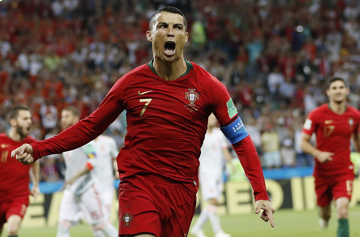

In [8]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

Let's check its corresponding caption:

In [9]:
example["text"]

'Ronaldo with Portugal at the 2018 World Cup'

## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values.

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [10]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [11]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [12]:
train_dataset = ImageCaptioningDataset(dataset, processor)

Let's check one example of the dataset:

In [13]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [16]:
processor.decode(batch["input_ids"][0])

'[CLS] ronaldo won la liga in his first season and received the pichichi trophy in his second. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

We can "denormalize" the pixel values to get back an image:

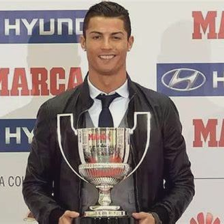

In [17]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Looks ok! Always important to check your data ;) see [this blog](http://karpathy.github.io/2019/04/25/recipe/) for a great overview of tips when training neural networks.

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [18]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [19]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.2085, grad_fn=<NllLossBackward0>)

## Train the model

Next, let's train the model! We use native PyTorch here.

As I created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then that's a great way to know that everything is working properly. See also the blog above.

In [20]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 12.964494705200195
Loss: 11.111571311950684
Loss: 10.357343673706055
Epoch: 1
Loss: 10.038032531738281
Loss: 9.806675910949707
Loss: 9.603583335876465
Epoch: 2
Loss: 9.375968933105469
Loss: 9.157510757446289
Loss: 9.036255836486816
Epoch: 3
Loss: 8.8162202835083
Loss: 8.726677894592285
Loss: 8.538525581359863
Epoch: 4
Loss: 8.409622192382812
Loss: 8.337718963623047
Loss: 8.210238456726074
Epoch: 5
Loss: 8.064653396606445
Loss: 7.9939680099487305
Loss: 7.901186466217041
Epoch: 6
Loss: 7.7691650390625
Loss: 7.689247131347656
Loss: 7.554281711578369
Epoch: 7
Loss: 7.480284214019775
Loss: 7.377499103546143
Loss: 7.231428146362305
Epoch: 8
Loss: 7.168395519256592
Loss: 7.0236687660217285
Loss: 6.967966556549072
Epoch: 9
Loss: 6.831971168518066
Loss: 6.761093616485596
Loss: 6.626452922821045
Epoch: 10
Loss: 6.528430461883545
Loss: 6.388844966888428
Loss: 6.3286213874816895
Epoch: 11
Loss: 6.202596187591553
Loss: 6.0657782554626465
Loss: 6.00399112701416
Epoch: 12
Loss: 5.89374065399169

## Inference

Now that we've trained the model, let's load the Maradona image and perform inference on it.

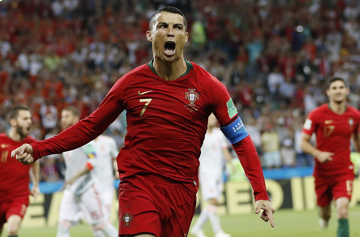

In [21]:
# load image
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [22]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

##o portugal


Great! We've successfully fine-tuned GIT on our tiny (image, text) dataset to generate captions of images of football players.